<img src="images/array_print.png" alt="Array Print" align="right"/>

# Array Print

<code>Array Print</code> takes a <code>.csv</code> containing a MITOMI-assayable library in a tabular format and returns a Scienion-compatible <code>.fld</code> file and a csv record of the array layout.

<br>

<div style="width:70px; height:auto; float:left; display:inline">Author:</div>
<div>Micah Olivas</div>
<div style="width:70px; height:auto; float:left; display:inline">Created:</div>
<div>Sept 27, 2021</div>
<div style="width:70px; height:auto; float:left; display:inline">Updated:</div>
<div>June 1, 2022</div>

In [6]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from ipyfilechooser import FileChooser
import mpl_toolkits.axes_grid1 as axes_grid1

import bin.array_print_core as ap

User .csv selection

In [56]:
# take user input and get current working directory
user_binning = str(input('Does your print require catalytic binning (specific to HT-MEK)? (yes or no)'))
cwd = os.getcwd()

if user_binning == 'yes':
    print('Select `.csv` containing library positions in tabular format')
    library_csv = FileChooser(cwd)
    display(library_csv)
    print('Select `.csv` containing catalytic bins of mutants in plate')
    fc_catalytic_bins = FileChooser(cwd)
    display(fc_catalytic_bins)
    # bin_desc = pd.read_csv('etc')
    
elif user_binning == 'no':
    print('Select `.csv` containing library positions in tabular format')
    library_csv = FileChooser(cwd)
    display(library_csv)

Select `.csv` containing library positions in tabular format


FileChooser(path='/Users/micaholivas/Desktop/Stanford/Research/Pipelines/Array-Print', filename='', title='', …

In [57]:
library_df, column_names, library_members = ap.csv_to_df(library_csv)

,plate_number,plate_position,member_name,catalytic_bin
0,1,A1,T2I,1
1,1,A2,R4G,1
2,1,A3,N10D,1
3,1,A4,N18S,1
4,1,A5,A31G,1
...,...,...,...,...
321,1,P20,CD_A392T,1
322,1,P21,CD_A461G,1
323,1,P22,CD_T468P,1
324,1,P23,CD_P491H,1


## Declare print dimensions
This script will maximize the number of sample replicates that appear in the final print given the size of your library, the print dimensions, and any space occuppied by skipped intervening rows. Additionally, you must declare how many blocks appear on your device and how many **empty columns**, if any, you'd like in your print.

In [15]:
# Number of columns and rows on device
total_columns = 32
total_rows = 56
empty_columns = 1
skip_rows = 'y'

# define replicate counting function
def count_replicates(library_df, total_columns, total_rows, empty_columns, skip_rows):
    library_members = set(library_df['plate_position'])
    library_size = len(library_members)

    if skip_rows == 'n':
        rows = total_rows
    elif skip_rows == 'y':
        rows = total_rows/2

    if empty_columns > 0:
        columns = total_columns - empty_columns
    else:
        columns = total_columns

    replicates = int((rows * columns)/(library_size))
    skip_rows = skip_rows.lower()

    if (empty_columns != 0) and (skip_rows == 'n'):
        print('Library contains', library_size, 'members. Accounting for skipped columns, the script will array at least', int(replicates), 'replicates per library member across', columns * rows, 'available chambers.')
    elif (empty_columns != 0) and (skip_rows == 'y'):
        print('Library contains', library_size, 'members. Accounting for skipped rows and columns, the script will array at least', int(replicates), 'replicates per library member across', columns * rows, 'available chambers.')
    elif skip_rows == 'n':
        print('Library contains', library_size, 'members. Will array at least', int(replicates), 'replicates per library member across', columns * rows, 'available chambers.')
    elif skip_rows == 'y':
        print('Library contains', library_size, 'members. Accounting for skipped rows, the script will array at least', int(replicates), 'replicates per library member across', columns * rows, 'available chambers.')
    else:
        print("Something looks wrong. Check your print presets.")

    return library_members, library_size, columns, rows, replicates, skip_rows

library_members, library_size, columns, rows, replicates, skip_rows = count_replicates(library_df, 
                                                                                           total_columns, 
                                                                                           total_rows, 
                                                                                           empty_columns, 
                                                                                           skip_rows)


# get available chambers
available_chambers = columns * rows

Library contains 326 members. Accounting for skipped rows and columns, the script will array at least 2 replicates per library member across 868.0 available chambers.


## Name file and generate array
**Change** the name of the file to include a description of your library and today's date. **BE AWARE** that each time you execute this cell, **the order of the array changes** and a new, timestamped `.csv` file is written to a project folder in the working directory.

In [44]:
filename = 'SHP2_library_230215'

Create a random array ordered by catalytic binning. This will add the lowest bins at the top of the chip

(867,)


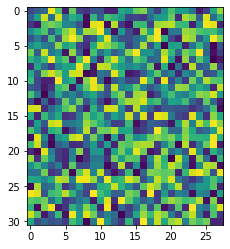

In [45]:
from datetime import datetime
timestamp = datetime.now().strftime('%Y_%m_%d__%H_%M_%S')

# first, create a dictionary of library members by catalytic bin
bin_to_mutant_dict = library_df.groupby('catalytic_bin')['plate_position'].apply(list).to_dict()
mutant_to_bin_dict = library_df.groupby('plate_position')['catalytic_bin'].apply(list).to_dict()

# next, iterate through the dictionary, adding the correct replicate number of
# mutants to a 1D numpy array
array_1D = np.zeros(0)

# Fill array, by catalytic bin if necessary
for k,v in bin_to_mutant_dict.items():
    bins_current = np.array(bin_to_mutant_dict[k] * replicates) # first, create a list of replicates for the current bin
    np.random.shuffle(bins_current)

    for i in range(int(round(available_chambers/len(mutant_to_bin_dict.keys()), 2) * len(bin_to_mutant_dict[k])) - bins_current.shape[0]):
        random_single = np.random.choice(bin_to_mutant_dict[k])
        bins_current = np.append(bins_current, random_single)

    array_1D = np.append(array_1D, bins_current)
    
print(array_1D.shape)

# Fill remaining chambers
# print(int((columns*rows) - array_1D.shape[0]))
for i in range(int((columns*rows) - array_1D.shape[0])):
    random_single = np.random.choice(list(mutant_to_bin_dict.keys()))
    array_1D = np.append(array_1D, random_single)

# last give a quick look at the print distribution
translate_dict_array_1D = dict(zip(np.unique(array_1D).tolist(), range(len(np.unique(array_1D).tolist()))))
plt.imshow(np.array([translate_dict_array_1D[well] for well in array_1D]).reshape(columns,int(rows)))

Next, insert blank rows and columns into the array

In [46]:
# first, create an empty array and add print array at odd rows
print_array_by_wells = np.zeros((int(total_rows), int(columns)), dtype='<U32')
print_array_by_wells[::2] = np.reshape(array_1D, (int(rows), int(columns)))

# next, add empty columns at random positions
for i in range(empty_columns):
    column_choice = np.random.randint(1, columns - 1) # don't add empties at either edge of the array
    print_array_by_wells = np.insert(print_array_by_wells, column_choice, np.zeros(total_rows, dtype='<U32'), axis=1)
    # print_array_by_wells[:, column_choice] = np.zeros(total_rows, dtype='<U32')

print_array_by_wells

array([['D20', 'F11', 'F20', ..., 'F12', 'J15', 'O8'],
       ['', '', '', ..., '', '', ''],
       ['F6', 'P1', 'G6', ..., 'M7', 'L3', 'H24'],
       ...,
       ['', '', '', ..., '', '', ''],
       ['B22', 'L20', 'C5', ..., 'M3', 'B4', 'B9'],
       ['', '', '', ..., '', '', '']], dtype='<U32')

Now, because we want to visualize the distribution of library members by catalytic proficiency, we need to create new arrays in which the member names have been substituted with their corresponding catalytic bin from the df at the top of the notebook

In [47]:
# array by catalytic bin
k = list(mutant_to_bin_dict.keys())
v = list(mutant_to_bin_dict.values())

print_array_by_bin = np.zeros_like(print_array_by_wells, dtype='int')
for key,val in zip(k,v):
    print_array_by_bin[print_array_by_wells==key] = int(val[0]) # val is a list here, even though it's supposed to be an int. need to change this at some point

# array by library number
k = np.array([i for i in library_members])
v = np.array(range(len(library_members)))

print_array_by_library_number = np.zeros_like(print_array_by_wells, dtype='int')
for key,val in zip(k,v):
    print_array_by_library_number[print_array_by_wells==key] = val

print(print_array_by_bin, '\n', print_array_by_library_number)

[[1 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]
 [1 1 1 ... 1 1 1]
 ...
 [0 0 0 ... 0 0 0]
 [1 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]] 
 [[ 46 229  25 ... 189 133 172]
 [  0   0   0 ...   0   0   0]
 [273 120  30 ... 169 199  95]
 ...
 [  0   0   0 ...   0   0   0]
 [222 151 198 ... 238 159 167]
 [  0   0   0 ...   0   0   0]]


/var/folders/tk/b6dtl2bj2sxbd1x_0nt6z7tr0000gn/T/ipykernel_57355/3131688168.py:58: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.
  fig.tight_layout()


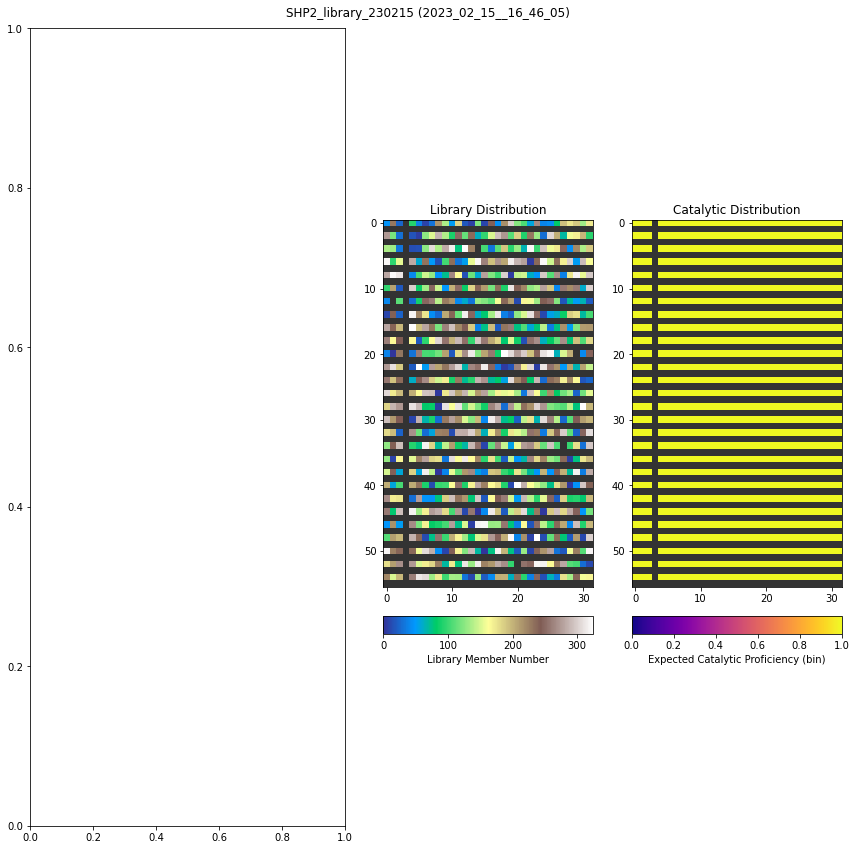

In [48]:
import matplotlib

# Initialize Figure
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, gridspec_kw={'width_ratios': [1.5, 1, 1]}, constrained_layout=True)
fig.set_figheight(12)
fig.set_figwidth(12)

# 384-well plate
cmap = plt.cm.spring  # define the colormap
# extract all colors from the .jet map
cmaplist = [cmap(i) for i in range(cmap.N)]
# force the first color entry to be grey
cmaplist[0] = (.5, .5, .5, 1.0)
cmap = matplotlib.colors.LinearSegmentedColormap.from_list(
    'Custom cmap', cmaplist, cmap.N)

# ax1.set_title('384-well sample plate')
# im1 = ax1.imshow(plate_384_vis, aspect='equal', cmap=cmap) # BuGn', 'BuGn_r', 'BuPu', 'BuPu_r', 'CMRmap', 'CMRmap_r', 'Dark2', 'Dark2_r', 'GnBu', 'GnBu_r', 'Greens', 
# divider4 = axes_grid1.make_axes_locatable(ax1)
# cax4 = divider4.append_axes('bottom', size='10%', pad=0.4)
# cbar4 = plt.colorbar(im1, cax=cax4, orientation='horizontal')
# cax4.set_xlabel('Origin 96-well Library Plate')


# Library member distribution on slide
cmap = plt.cm.terrain  # define the colormap
# extract all colors from the .jet map
cmaplist = [cmap(i) for i in range(cmap.N)]
# force the first color entry to be grey
cmaplist[0] = (.2, .2, .2, 1.0)
cmap = matplotlib.colors.LinearSegmentedColormap.from_list(
    'Custom cmap', cmaplist, cmap.N)

ax2.set_title('Library Distribution')
im2 = ax2.imshow(print_array_by_library_number, aspect='equal', cmap=cmap)
divider4 = axes_grid1.make_axes_locatable(ax2)
cax4 = divider4.append_axes('bottom', size='5%', pad=0.4)
cbar4 = plt.colorbar(im2, cax=cax4, orientation='horizontal')
cax4.set_xlabel('Library Member Number')

# Catalytic distribution on slide
cmap = plt.cm.plasma  # define the colormap
# extract all colors from the .jet map
cmaplist = [cmap(i) for i in range(cmap.N)]
# force the first color entry to be grey
cmaplist[0] = (.2, .2, .2, 1.0)
cmap = matplotlib.colors.LinearSegmentedColormap.from_list(
    'Custom cmap', cmaplist, cmap.N)

ax3.set_title('Catalytic Distribution')
im3 = ax3.imshow(print_array_by_bin, aspect='equal', cmap=cmap)
divider4 = axes_grid1.make_axes_locatable(ax3)
cax4 = divider4.append_axes('bottom', size='5%', pad=0.4)
cbar4 = plt.colorbar(im3, cax=cax4, orientation='horizontal')
cax4.set_xlabel('Expected Catalytic Proficiency (bin)')

fig.suptitle(filename + ' (' + timestamp + ')')
fig.tight_layout()
fig.savefig(f'/Users/micaholivas/Desktop/Stanford/Research/Pipelines/Array-Print/{filename}_{timestamp}.png', dpi=200)
plt.show()

Lastly, count each member to ensure none were lost

In [52]:
unique, counts = np.unique(print_array_by_wells, return_counts=True)
np.column_stack((unique, counts))

array([  2,   2,   2,   2,   2,   2,   2,   2,   2,   2,   2,   2,   2,
         2,   2,   2,   2,   2,   2,   2,   2,   2,   2,   2,   2,   2,
         2,   2,   2,   2,   2,   2,   2,   2,   2,   2,   2,   2,   2,
         2,   2,   2,   2,   2,   2,   2,   2,   2,   2,   2,   2,   2,
         2,   2,   2,   2,   2,   2,   2,   2,   2,   2,   2,   2,   2,
         2,   2,   2,   2,   2,   2,   2,   2,   2,   2,   2,   2,   2,
         2,   2,   2,   2,   2,   2,   2,   2,   2,   2,   2,   2,   2,
         2,   2,   2,   2,   2,   2,   2,   2,   2,   2,   2,   2,   2,
         2,   2,   2,   2,   2,   2,   2,   2,   2,   2,   2,   2,   2,
         2,   2,   2,   2,   2,   2,   2,   2,   2,   2,   2,   2,   2,
         2,   2,   2,   2,   2,   2,   2,   2,   2,   2,   2,   2,   2,
         2,   2,   2,   2,   2,   2,   2,   2,   2,   2,   2,   2,   2,
         2,   2,   2,   2,   2,   2,   2,   2,   2,   2,   2,   2,   2,
         2,   2,   2,   2,   3,   3,   3,   3,   3,   3,   3,   

## Output field file-formatted position list
Finally, the following cell writes a `.txt` file containing the array position list to the project folder. This text can be copied into a Scienion-compattible `.fld` file for printing. Note that a new, timestamped `.txt` file is written each time you execute this cell. 

In [53]:
print_df = pd.DataFrame(np.flip(print_array_by_wells, axis=1)) # printing on Scienion flips the array
print_df

,0,1,2,3,4,5,6,7,8,9,...,22,23,24,25,26,27,28,29,30,31
0,O8,J15,F12,N22,J3,D15,B17,G14,J1,J11,...,C7,D14,M12,B2,L22,P24,,F20,F11,D20
1,,,,,,,,,,,...,,,,,,,,,,
2,H24,L3,M7,L5,B16,C6,K11,F7,P15,F11,...,L19,F1,K5,A6,I6,K1,,G6,P1,F6
3,,,,,,,,,,,...,,,,,,,,,,
4,N6,H13,O9,N10,J22,E5,L24,K10,H3,B6,...,B10,C7,O12,A6,P21,P18,,A12,E12,H13
5,,,,,,,,,,,...,,,,,,,,,,
6,P17,J7,E13,D12,N19,P7,N5,E1,L14,D22,...,J14,N20,B19,D4,I5,B10,,H19,P9,N3
7,,,,,,,,,,,...,,,,,,,,,,
8,D19,J6,L4,N22,O5,J5,C10,D19,K16,J19,...,D24,K16,P6,N5,H5,F4,,D7,E1,G5
9,,,,,,,,,,,...,,,,,,,,,,


## Save `fld` file body in `txt` output

Last, export this array to a fld file text output

In [55]:
# create a new timestamp for the fld file
timestamp = datetime.now().strftime('%Y_%m_%d__%H_%M_%S')


def display_fld(print_df, total_columns, total_rows):
    for i in range(0, total_columns):
        for j in range(0, total_rows):
            current_fld_loc = str(i + 1) + '/' + str(j + 1) # add ones to change from 0-indexing
            current_array_val = print_df.iloc[j][i]

            # Insert blank for NaN values
            if type(current_array_val) != str:
                current_array_val = '\t'

            array_loc_print = current_array_val
            
            # Add a plate number to only the non-blank wells
            if len(array_loc_print) >= 1:
                array_loc_print = '1' + array_loc_print

            print(current_fld_loc + '\t' + array_loc_print + ',' + '\t' + '1,')

def write_fld(filename, print_df, total_columns, total_rows):
    with open(f'/Users/micaholivas/Desktop/Stanford/Research/Pipelines/Array-Print/{filename}_{timestamp}_fld.txt', 'w') as f:
        for i in range(0, total_columns):
            for j in range(0, total_rows):
                current_fld_loc = str(i + 1) + '/' + str(j + 1) # add ones to change from 0-indexing
                current_array_val = print_df.iloc[j][i]

                # Insert blank for NaN values
                if type(current_array_val) != str:
                    current_array_val = '\t'

                array_loc_print = current_array_val
                
                # Add a plate number to only the non-blank wells
                if len(array_loc_print) >= 1:
                    array_loc_print = '1' + array_loc_print

                f.write(current_fld_loc + '\t' + array_loc_print + ',' + '\t' + '1,' + '\n')


display_fld(print_df, total_columns, total_rows)
write_fld(filename, print_df, total_columns, total_rows)

1/1	1O8,	1,
1/2	,	1,
1/3	1H24,	1,
1/4	,	1,
1/5	1N6,	1,
1/6	,	1,
1/7	1P17,	1,
1/8	,	1,
1/9	1D19,	1,
1/10	,	1,
1/11	1I15,	1,
1/12	,	1,
1/13	1I17,	1,
1/14	,	1,
1/15	1O16,	1,
1/16	,	1,
1/17	1E2,	1,
1/18	,	1,
1/19	1D5,	1,
1/20	,	1,
1/21	1J8,	1,
1/22	,	1,
1/23	1M17,	1,
1/24	,	1,
1/25	1F20,	1,
1/26	,	1,
1/27	1H19,	1,
1/28	,	1,
1/29	1C5,	1,
1/30	,	1,
1/31	1L3,	1,
1/32	,	1,
1/33	1N15,	1,
1/34	,	1,
1/35	1M15,	1,
1/36	,	1,
1/37	1N21,	1,
1/38	,	1,
1/39	1E17,	1,
1/40	,	1,
1/41	1A3,	1,
1/42	,	1,
1/43	1N21,	1,
1/44	,	1,
1/45	1O6,	1,
1/46	,	1,
1/47	1L3,	1,
1/48	,	1,
1/49	1D12,	1,
1/50	,	1,
1/51	1L4,	1,
1/52	,	1,
1/53	1G3,	1,
1/54	,	1,
1/55	1B9,	1,
1/56	,	1,
2/1	1J15,	1,
2/2	,	1,
2/3	1L3,	1,
2/4	,	1,
2/5	1H13,	1,
2/6	,	1,
2/7	1J7,	1,
2/8	,	1,
2/9	1J6,	1,
2/10	,	1,
2/11	1I12,	1,
2/12	,	1,
2/13	1P19,	1,
2/14	,	1,
2/15	1B16,	1,
2/16	,	1,
2/17	1D6,	1,
2/18	,	1,
2/19	1E7,	1,
2/20	,	1,
2/21	1F10,	1,
2/22	,	1,
2/23	1H12,	1,
2/24	,	1,
2/25	1K2,	1,
2/26	,	1,
2/27	1J16,	1,
2/28	,	1,
2/29	1A8,	1,
2/30	,	1,
2/31	1

In [ ]:
from datetime import datetime
now = datetime.now().strftime('%Y_%m_%d_%H%M:%S') # .replace(' ', '_')
now

### Miscellaneous
Generate a random mutant library for script development or a tutorial

In [ ]:
25 % 24

In [ ]:
import numpy as np
x = 253

# prints plate, well, mutant, bin
# Selects from 5 plates, 5 rows, 20 columns, 8 starting amino acids, 300 protein positions, 3 ending amino acids
for i in range(x):
    row = round(i/24)
    column = i % 24
    row = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P'][row]
    print(str(np.random.choice(1)) + ',' + str(row) + str(column) + ',' + str(np.random.choice(['P', 'A', 'S', 'I', 'K', 'N', 'L', 'R', 'D', 'N', 'M'])) + str(np.random.choice(600)) + str(np.random.choice(['V', 'G', 'A'])) + ',' + str(np.random.choice(10)))